In [84]:
import math
from dataclasses import dataclass, field, InitVar, asdict
from graphviz import Digraph


@dataclass(eq=False)
class Value:
    data: float
    prev: set = field(compare=False, repr=False, default_factory=set)
    op: str = field(compare=False, repr=False, default='')
    label: str = field(compare=False, default='')
    grad: float = field(compare=False, default=0.0)

    def __post_init__(self, ):
        # validate op
        if self.op not in ('', '+', '*', 'tanh'):
            raise ValueError("op not in ('', '+', '*')")
            
        # build label from parts if not given
        if not self.label:
            if self.op in ('+', '*'):
                label = self.op.join(p.label for p in self.prev)
                self.label = f"({label})"
            if self.op == 'tanh':
                self.label = f"tanh({next(iter(self.prev)).label})"
        
        self.prev = set(self.prev)

    def __add__(self, other):
        return Value(self.data + other.data, prev=(self, other), op='+')
        
    def __mul__(self, other):
        return Value(self.data * other.data, prev=(self, other), op='*')

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, prev={self}, op='tanh')
        return out

    ### visualization
    
    def viz(self):
        return Value._draw_dot(self)

    @staticmethod
    def _draw_dot(v, rankdir='TD'):
        dot = Digraph(format='svg', 
                      graph_attr={'rankdir': rankdir}
                     )
        nodes, edges = v._trace()
        for n in nodes:
            print('draw', n)
            uid = str(id(n))
            dot.node(name=uid, label=f"{{ {n.op} | {n.label} | {n.data:.4f} (grad {n.grad}) }}", shape='record')
        for n1, n2 in edges:
            dot.edge(str(id(n1)), str(id(n2)))
        return dot

    def _trace(self):
        nodes, edges = set(), set()
        def build(v):
            print('trace1', v)
            print('nodes', nodes)
            if v not in nodes:
                print('trace2', v)
                nodes.add(v)
                for child in v.prev:
                    edges.add((child, v))
                    build(child)
            else: 
                print(f'\n{v} in {nodes}\n')
                print(hash(v))
                for node in nodes:
                    print(hash(node), node)
        build(self)
        return nodes, edges


v = Value(2.0, label='a') * Value(3.0, label='b') + Value(1.0, label='c')
v2 = v.tanh()
assert v.data == 7.0
assert v.prev == {Value(data=1.0), Value(data=6.0)}

AssertionError: 

In [77]:
v.prev

{Value(data=1.0, label='c', grad=0.0),
 Value(data=6.0, label='(a*b)', grad=0.0)}

In [78]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.7, label='b')

n = x1*w1 + x2*w2 + b

trace1 Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0)
nodes set()
trace2 Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0)
trace1 Value(data=6.7, label='b', grad=0.0)
nodes {Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0)}
trace2 Value(data=6.7, label='b', grad=0.0)
trace1 Value(data=-6.0, label='((x1*w1)+(x2*w2))', grad=0.0)
nodes {Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0), Value(data=6.7, label='b', grad=0.0)}
trace2 Value(data=-6.0, label='((x1*w1)+(x2*w2))', grad=0.0)
trace1 Value(data=-6.0, label='(x1*w1)', grad=0.0)
nodes {Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0), Value(data=6.7, label='b', grad=0.0), Value(data=-6.0, label='((x1*w1)+(x2*w2))', grad=0.0)}
trace2 Value(data=-6.0, label='(x1*w1)', grad=0.0)
trace1 Value(data=2.0, label='x1', grad=0.0)
nodes {Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0), Value(data=-6.0, label

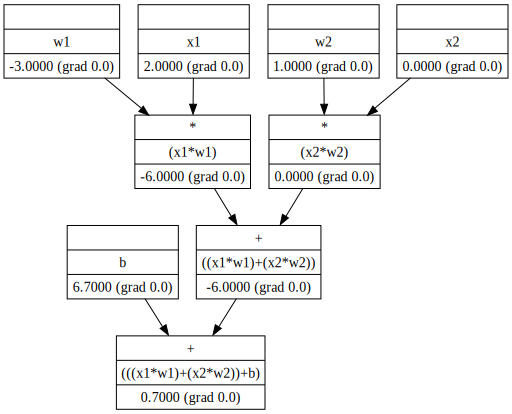

In [79]:
n.viz()

In [70]:
n._trace()

trace1 Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0)
nodes set()
trace2 Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0)
trace1 Value(data=6.7, label='b', grad=0.0)
nodes {Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0)}
trace2 Value(data=6.7, label='b', grad=0.0)
trace1 Value(data=-6.0, label='((x1*w1)+(x2*w2))', grad=0.0)
nodes {Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0), Value(data=6.7, label='b', grad=0.0)}
trace2 Value(data=-6.0, label='((x1*w1)+(x2*w2))', grad=0.0)
trace1 Value(data=0.0, label='(x2*w2)', grad=0.0)
nodes {Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0), Value(data=6.7, label='b', grad=0.0), Value(data=-6.0, label='((x1*w1)+(x2*w2))', grad=0.0)}
trace2 Value(data=0.0, label='(x2*w2)', grad=0.0)
trace1 Value(data=0.0, label='x2', grad=0.0)
nodes {Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0), Value(data=6.7, label='b

({Value(data=-6.0, label='((x1*w1)+(x2*w2))', grad=0.0),
  Value(data=0.0, label='(x2*w2)', grad=0.0),
  Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0),
  Value(data=1.0, label='w2', grad=0.0),
  Value(data=6.7, label='b', grad=0.0)},
 {(Value(data=-6.0, label='((x1*w1)+(x2*w2))', grad=0.0),
   Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0)),
  (Value(data=-6.0, label='(x1*w1)', grad=0.0),
   Value(data=-6.0, label='((x1*w1)+(x2*w2))', grad=0.0)),
  (Value(data=0.0, label='(x2*w2)', grad=0.0),
   Value(data=-6.0, label='((x1*w1)+(x2*w2))', grad=0.0)),
  (Value(data=0.0, label='x2', grad=0.0),
   Value(data=0.0, label='(x2*w2)', grad=0.0)),
  (Value(data=1.0, label='w2', grad=0.0),
   Value(data=0.0, label='(x2*w2)', grad=0.0)),
  (Value(data=6.7, label='b', grad=0.0),
   Value(data=0.7000000000000002, label='(((x1*w1)+(x2*w2))+b)', grad=0.0))})

In [59]:
hash(wyy)

-9198840626394771241

In [60]:
nodes

wyy = list(n.prev)[1]

wyy._trace()

NameError: name 'nodes' is not defined

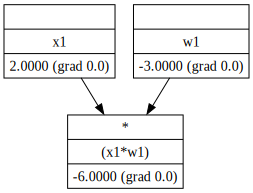

In [31]:
list(wyy.prev)[1].viz()

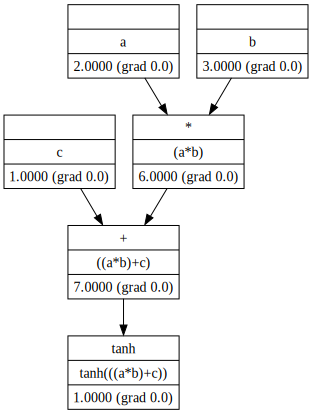

In [12]:
v2.viz()